# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [9]:
# Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')
data.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
sample = data.sample(n=100000, random_state=1)
sample

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6322570,688,CASH_IN,23557.12,C867750533,8059.00,31616.12,C1026934669,169508.66,145951.53,0,0
3621196,274,PAYMENT,6236.13,C601099070,0.00,0.00,M701283411,0.00,0.00,0,0
1226256,133,PAYMENT,33981.87,C279540931,18745.72,0.00,M577905776,0.00,0.00,0,0
2803274,225,CASH_OUT,263006.42,C11675531,20072.00,0.00,C529577791,390253.56,653259.98,0,0
3201247,249,CASH_OUT,152013.74,C530649214,20765.00,0.00,C1304175579,252719.19,404732.93,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4225513,306,CASH_OUT,15627.09,C1059072914,81424.00,65796.91,C759673946,0.00,15627.09,0,0
4989642,352,PAYMENT,4539.99,C1543222456,31492.00,26952.01,M441713839,0.00,0.00,0,0
2099701,182,CASH_IN,182400.10,C171437065,1060.00,183460.10,C1175649845,0.00,0.00,0,0
249322,14,PAYMENT,3673.04,C1831253634,19837.00,16163.96,M912660596,0.00,0.00,0,0


In [4]:
sample.shape

(100000, 11)

### What is the distribution of the outcome? 

In [6]:
# Your response here
sample['isFraud'].value_counts()

0    99876
1      124
Name: isFraud, dtype: int64

In [8]:
# sample['isFlaggedFraud'].unique()

array([0])

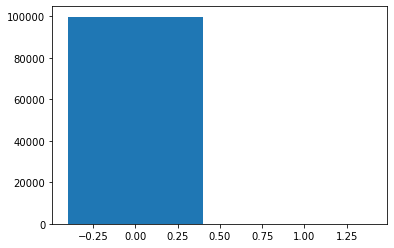

In [10]:
plt.bar(sample['isFraud'].value_counts().index, sample['isFraud'].value_counts().values)
plt.show()

In [ ]:
# The outcome column of the dataset sample is very unbalanced

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [21]:
# Your code here
sample.dtypes
sample = sample.drop(columns=['type', 'nameOrig', 'nameDest'])

In [22]:
sample.dtypes

step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [12]:
sample.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6322570,688,CASH_IN,23557.12,C867750533,8059.00,31616.12,C1026934669,169508.66,145951.53,0,0
3621196,274,PAYMENT,6236.13,C601099070,0.00,0.00,M701283411,0.00,0.00,0,0
1226256,133,PAYMENT,33981.87,C279540931,18745.72,0.00,M577905776,0.00,0.00,0,0
2803274,225,CASH_OUT,263006.42,C11675531,20072.00,0.00,C529577791,390253.56,653259.98,0,0
3201247,249,CASH_OUT,152013.74,C530649214,20765.00,0.00,C1304175579,252719.19,404732.93,0,0


### Run a logisitc regression classifier and evaluate its accuracy.

In [23]:
# Your code here
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Train test split
y = sample['isFraud']
X = sample.drop('isFraud', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Model
LR = LogisticRegression()

# Train
LR.fit(X_train, y_train)

# Evaluate
LR.score(X_test, y_test)

0.99836

### Now pick a model of your choice and evaluate its accuracy.

In [24]:
# Your code here
from sklearn.metrics import classification_report, confusion_matrix

pred = LR.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24971
           1       0.38      0.69      0.49        29

    accuracy                           1.00     25000
   macro avg       0.69      0.84      0.75     25000
weighted avg       1.00      1.00      1.00     25000



### Which model worked better and how do you know?

In [25]:
# Your response here
# Since the sample is very unbalanced I do a resampling with SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=1, sampling_strategy=1.0)  

X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)

In [26]:
LR = LogisticRegression()
LR.fit(X_train_SMOTE, y_train_SMOTE)

pred = LR.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     24971
           1       0.04      0.97      0.08        29

    accuracy                           0.97     25000
   macro avg       0.52      0.97      0.53     25000
weighted avg       1.00      0.97      0.99     25000



In [ ]:
# The Logistic Regression works well, but only after resampling the dataset

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.